# Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,\
                         export_graphviz
from treeinterpreter import treeinterpreter as ti
import pydotplus
from IPython.display import Image, display

from tree_interp_functions import *

In [2]:
# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
blue, green, red, purple, yellow, cyan = sns.color_palette()

# Load Data

In [3]:
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
abalone_df = pd.read_csv('abalone.csv', names=column_names)
abalone_df['sex'] = abalone_df['sex'].map({'F': 0, 'I': 1, 'M': 2})
abalone_df['y'] = abalone_df.rings.map(lambda x: 1 if x > 9 else 0)
abalone_df.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,y
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,1
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0


In [4]:
# Set up training and sets sets.
abalone_train, abalone_test = train_test_split(abalone_df, test_size=0.2,
                                               random_state=0)

X_train = abalone_train.iloc[:, :-2]
y_train = abalone_train.y

X_test = abalone_test.iloc[:, :-2]
y_test = abalone_test.y

X_train = X_train.copy().reset_index(drop=True)
y_train = y_train.copy().reset_index(drop=True)
X_test = X_test.copy().reset_index(drop=True)
y_test = y_test.copy().reset_index(drop=True)

# Build Model

In [5]:
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                random_state=0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [6]:
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=10,
                                n_estimators=100, random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

## Create feature contribution
We use the `ti.predict` function to get our contributions. This is a 3d array which represents the contribution for each example, feature, and class label.

In [7]:
dt_pred, dt_bias, dt_contrib = ti.predict(dt_clf, X_test)
rf_pred, rf_bias, rf_contrib = ti.predict(rf_clf, X_test)

# Create DataFrame containing contributions
dt_contrib_df = pd.DataFrame(dt_contrib[:, :, 1], columns=X_test.columns)
rf_contrib_df = pd.DataFrame(rf_contrib[:, :, 1], columns=X_test.columns)

# Visualizing Decision Trees

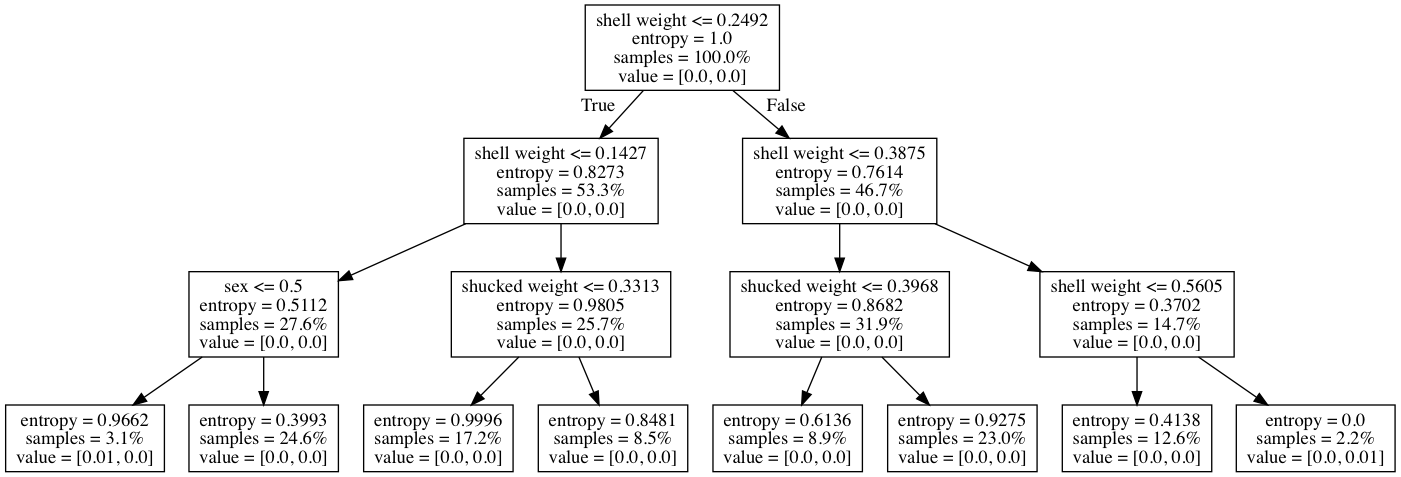

In [8]:
dot_data = export_graphviz(dt_clf,
                           out_file=None,
                           feature_names=X_train.columns,
                           proportion=True
                          )
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# Plot Feature Importances

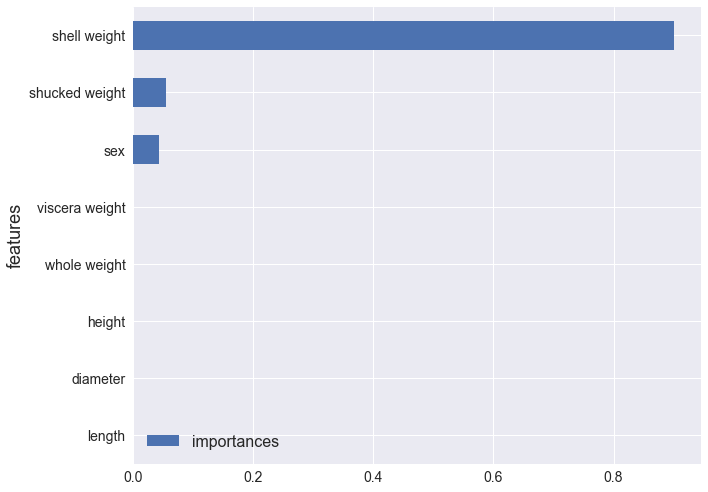

In [9]:
df_importances = pd.DataFrame({'features': X_train.columns,
                               'importances': dt_clf.feature_importances_
                              })
df_importances\
    .set_index('features')\
    .sort_values('importances')\
    .plot(kind='barh')
plt.tight_layout()

# Plot Feature Contributions
For each observation, we can plot how its features affect its score in the model.

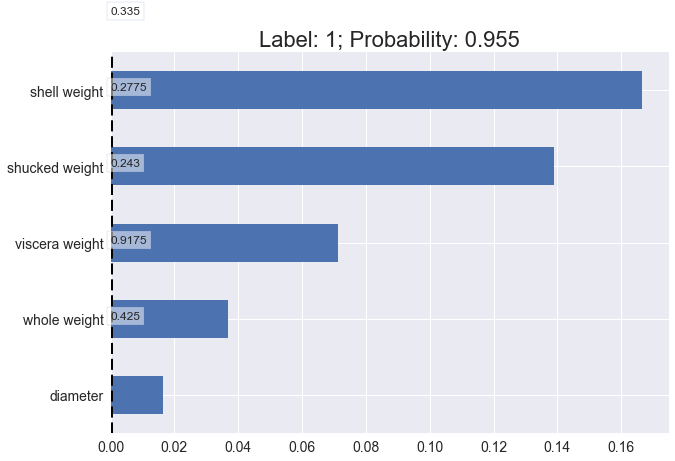

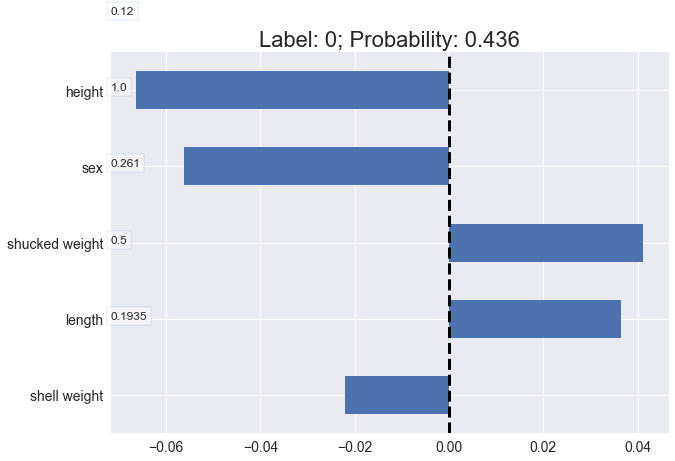

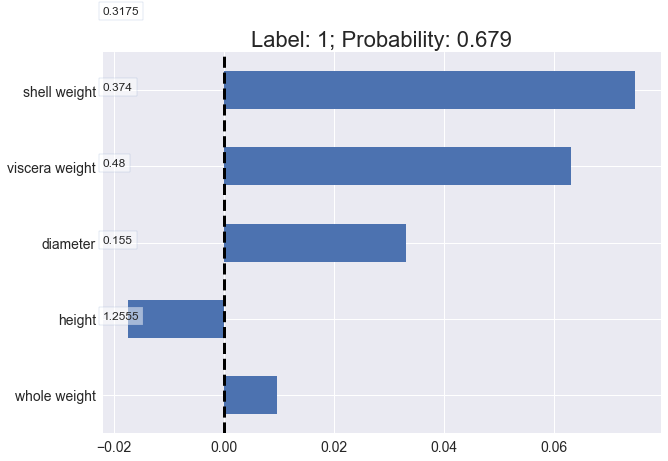

In [144]:
for i in xrange(3):
    _df = plot_top_feat_contrib(rf_clf, rf_contrib_df, X_test, y_test, i,
                                num_features=5,
                                order_by='contribution'
                               )

We can also plot them against the contributions of all observations.

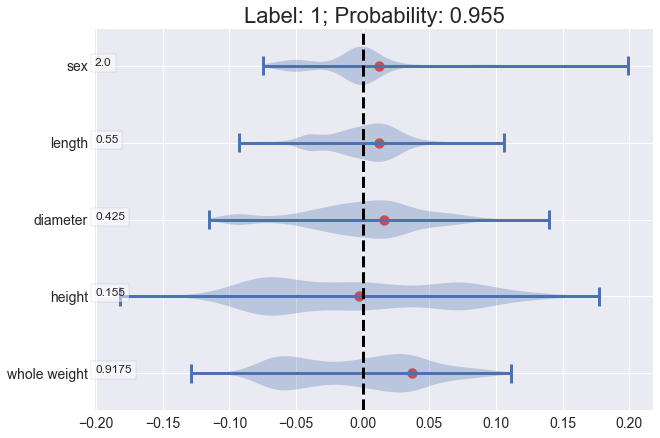

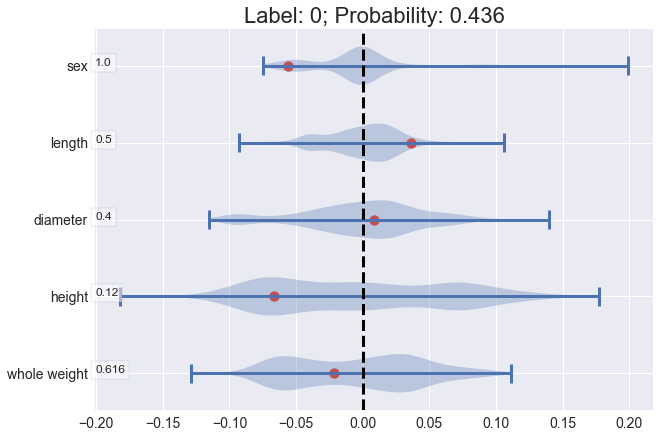

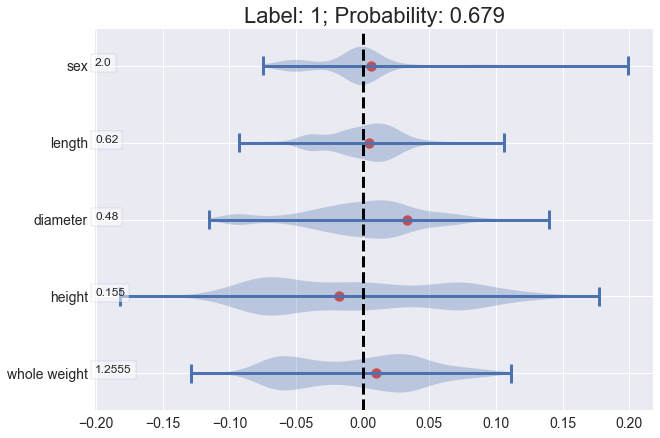

In [152]:
for i in xrange(3):
    _df = plot_top_feat_contrib(rf_clf, rf_contrib_df, X_test, y_test, i,
                                num_features=5,
                                order_by='natural',
                                violin=True
                               )

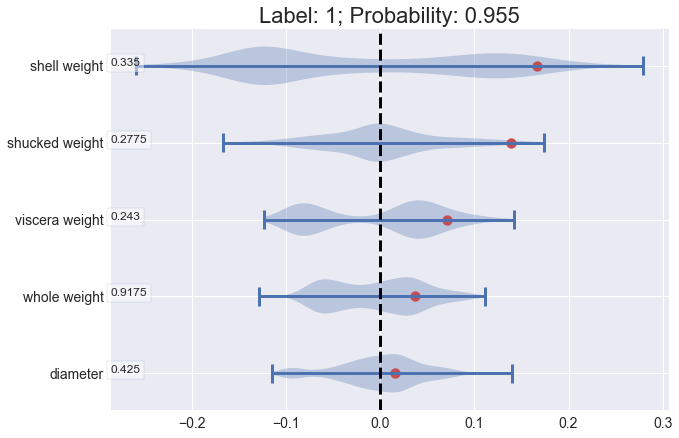

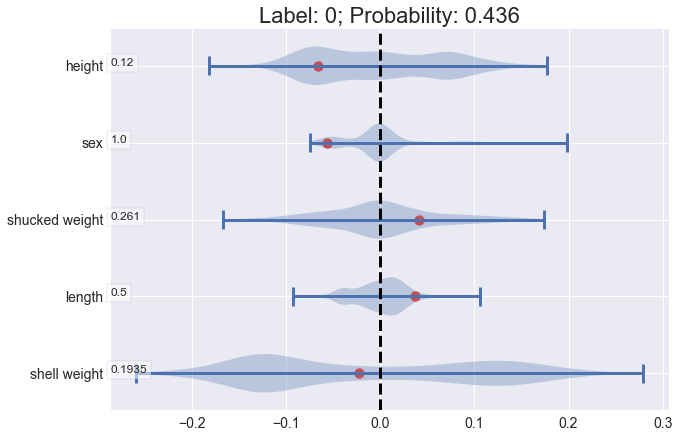

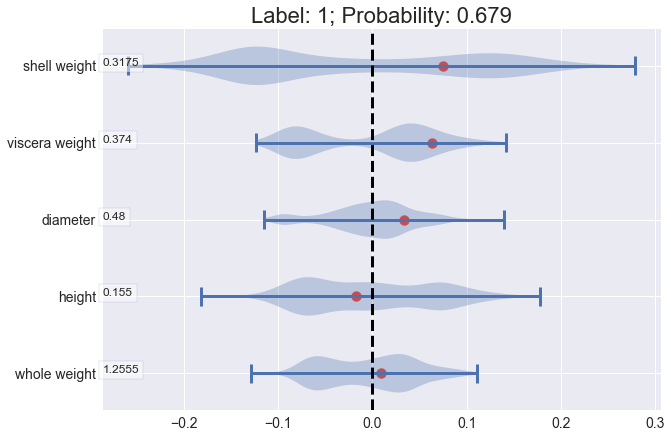

In [147]:
for i in xrange(3):
    _df = plot_top_feat_contrib(rf_clf, rf_contrib_df, X_test, y_test, i,
                                num_features=5,
                                order_by='contribution',
                                violin=True
                               )

# Plotting Individual Features
We now plot individual feature values against their contribution. This should give us some pattern on how each feature affects the contribution of that feature in the model.

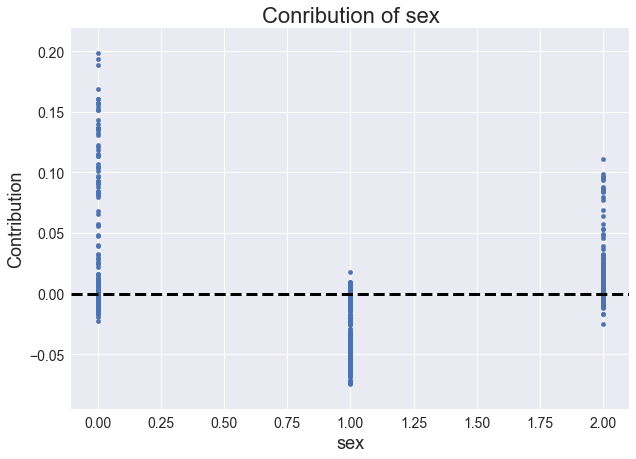

In [14]:
plot_single_feat_contrib('sex', X_test, rf_contrib_df)

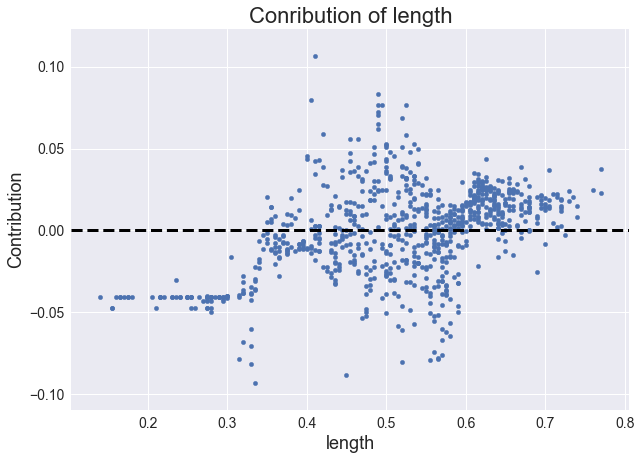

In [15]:
plot_single_feat_contrib('length', X_test, rf_contrib_df)

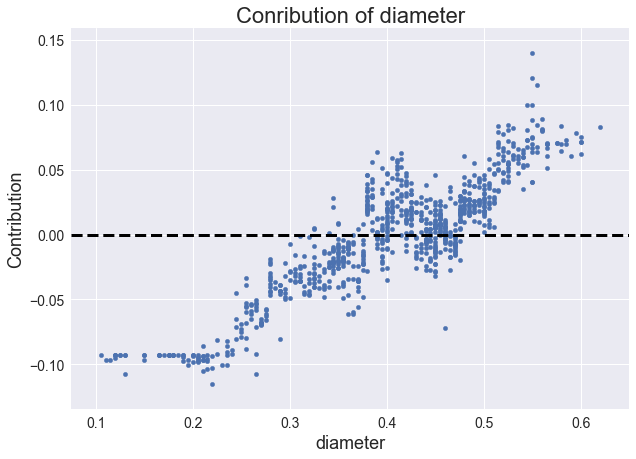

In [38]:
plot_single_feat_contrib('diameter', X_test, rf_contrib_df)